In [7]:
import pandas as pd

# Read the kills data and filter out 2024
kills_df = pd.read_csv('yearly_kills_by_state.csv')
kills_df = kills_df[kills_df['year'] != 2024]

# Read population data and set proper column names for 2013-2019
pop_2013_2019 = pd.read_csv('state_pop_2013_2019.csv', skiprows=4)
years_2013_2019 = ['state', '2010_census', '2010_base', '2010', '2011', '2012', '2013', 
                   '2014', '2015', '2016', '2017', '2018', '2019']
pop_2013_2019.columns = years_2013_2019

# Read population data and set proper column names for 2020-2023
pop_2020_2023 = pd.read_csv('state_pop_2020_2023.csv', skiprows=4)
years_2020_2023 = ['state', '2020_base', '2020', '2021', '2022', '2023']
pop_2020_2023.columns = years_2020_2023

# Filter for state rows and clean state names
pop_2013_2019 = pop_2013_2019[pop_2013_2019['state'].str.startswith('.', na=False)]
pop_2013_2019['state'] = pop_2013_2019['state'].str.replace('.', '')

pop_2020_2023 = pop_2020_2023[pop_2020_2023['state'].str.startswith('.', na=False)]
pop_2020_2023['state'] = pop_2020_2023['state'].str.replace('.', '')

# Melt the dataframes to get year-wise data
pop_2013_2019_melted = pd.melt(pop_2013_2019, 
                              id_vars=['state'],
                              value_vars=['2013', '2014', '2015', '2016', '2017', '2018', '2019'],
                              var_name='year',
                              value_name='population')

pop_2020_2023_melted = pd.melt(pop_2020_2023,
                              id_vars=['state'],
                              value_vars=['2020', '2021', '2022', '2023'],
                              var_name='year',
                              value_name='population')

# Combine population data
pop_df = pd.concat([pop_2013_2019_melted, pop_2020_2023_melted])

# Clean population values and convert to numeric
pop_df['population'] = pop_df['population'].str.replace(',', '')
pop_df['population'] = pd.to_numeric(pop_df['population'], errors='coerce')
pop_df['year'] = pd.to_numeric(pop_df['year'])

# State name mapping dictionary
state_name_mapping = {
    'Alaska': 'AK', 'Alabama': 'AL', 'Arkansas': 'AR', 'Arizona': 'AZ',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Iowa': 'IA',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Massachusetts': 'MA', 'Maryland': 'MD',
    'Maine': 'ME', 'Michigan': 'MI', 'Minnesota': 'MN', 'Missouri': 'MO',
    'Mississippi': 'MS', 'Montana': 'MT', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Nebraska': 'NE', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'Nevada': 'NV', 'New York': 'NY', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Virginia': 'VA', 'Vermont': 'VT', 'Washington': 'WA', 'Wisconsin': 'WI',
    'West Virginia': 'WV', 'Wyoming': 'WY'
}

# Apply state name mapping
pop_df['state'] = pop_df['state'].replace(state_name_mapping)

# Merge with kills data
merged_df = pd.merge(kills_df, pop_df, on=['state', 'year'], how='left')

# Calculate kills per million population
merged_df['kills_per_million'] = (merged_df['total_kills'] / merged_df['population']) * 1000000
merged_df['kills_per_million'] = merged_df['kills_per_million'].round(2)

# Select and arrange final columns
final_df = merged_df[['state', 'year', 'Bodycam_Policy', 'total_kills', 'population', 'kills_per_million']]

# Save to CSV
final_df.to_csv('yearly_kills_by_state_with_per_capita.csv', index=False)

print("First few rows of the result:")
print(final_df.head())
print("\nFile has been saved as 'yearly_kills_by_state_with_per_capita.csv'")

First few rows of the result:
  state  year  Bodycam_Policy  total_kills  population  kills_per_million
0    AK  2013             0.0            4    737068.0               5.43
1    AK  2014             0.0            2    736283.0               2.72
2    AK  2015             0.0            4    737498.0               5.42
3    AK  2016             0.0            7    741456.0               9.44
4    AK  2017             0.0            8    739700.0              10.82

File has been saved as 'yearly_kills_by_state_with_per_capita.csv'


In [10]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_per_capita.csv')

# dropt unnecessary columns
df = df.drop(columns=['population', 'total_kills'])

# Create state groups
group_1_states = ['CT', 'NJ', 'NM']
group_2_states = ['CO', 'IL', 'MD', 'SC']

# Create the new variable using numpy.select
conditions = [
    df['state'].isin(group_1_states),
    df['state'].isin(group_2_states)
]
choices = [1, 2]
df['treatment'] = np.select(conditions, choices, default=0)

# Save the updated dataframe
df.to_csv('yearly_kills_by_state_with_treatment.csv', index=False)

# Print first few rows and a summary of the groupings
print("First few rows of the result:")
print(df.head())
print("\nNumber of states in each group:")
print(df.groupby('treatment')['state'].nunique())
print("\nStates in each group:")
for group in [0, 1, 2]:
    states = sorted(df[df['treatment'] == group]['state'].unique())
    print(f"\nGroup {group}: {states}")

print("\nFile has been saved as 'yearly_kills_by_state_with_groups.csv'")

First few rows of the result:
  state  year  Bodycam_Policy  kills_per_million  treatment
0    AK  2013             0.0               5.43          0
1    AK  2014             0.0               2.72          0
2    AK  2015             0.0               5.42          0
3    AK  2016             0.0               9.44          0
4    AK  2017             0.0              10.82          0

Number of states in each group:
treatment
0    44
1     3
2     4
Name: state, dtype: int64

States in each group:

Group 0: ['AK', 'AL', 'AR', 'AZ', 'CA', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IN', 'KS', 'KY', 'LA', 'MA', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

Group 1: ['CT', 'NJ', 'NM']

Group 2: ['CO', 'IL', 'MD', 'SC']

File has been saved as 'yearly_kills_by_state_with_groups.csv'


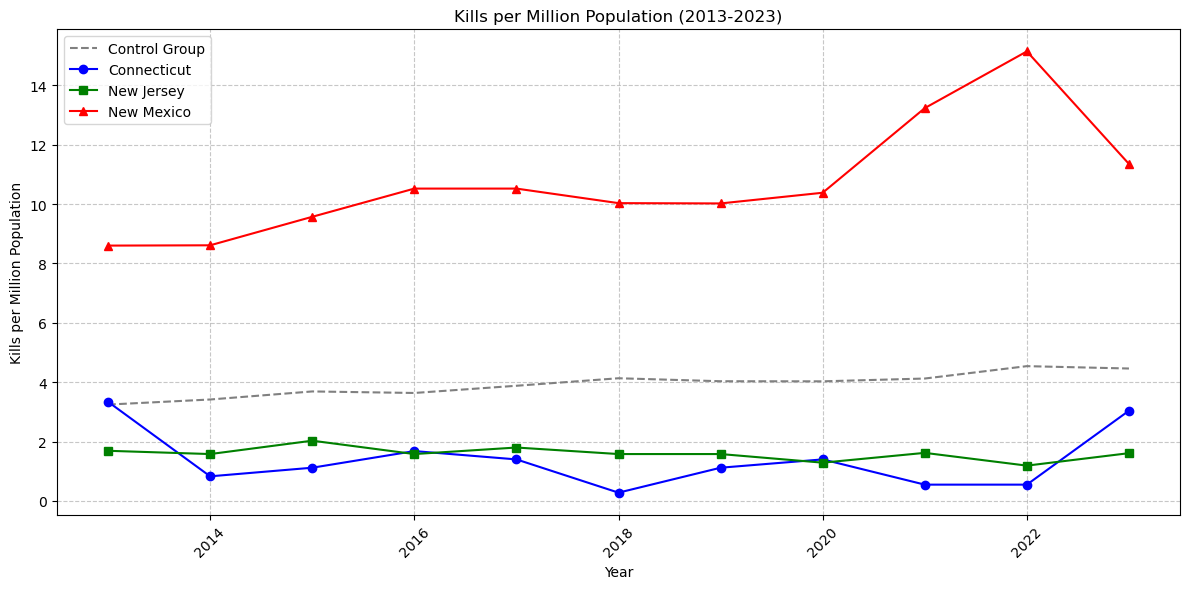


Average kills per million over the entire period:
Control Group: 3.93
Connecticut: 1.39
New Jersey: 1.60
New Mexico: 10.72


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('yearly_kills_by_state_with_treatment.csv')

# Filter for years 2013-2023
df = df[(df['year'] >= 2013) & (df['year'] <= 2023)]

# Calculate control group average (states with treatment = 0)
control_group = df[df['treatment'] == 0].groupby('year')['kills_per_million'].mean().reset_index()

# Get data for group 1 states (CT, NJ, NM)
ct_data = df[df['state'] == 'CT']
nj_data = df[df['state'] == 'NJ']
nm_data = df[df['state'] == 'NM']

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each line
plt.plot(control_group['year'], control_group['kills_per_million'], '--', label='Control Group', color='gray')
plt.plot(ct_data['year'], ct_data['kills_per_million'], '-o', label='Connecticut', color='blue')
plt.plot(nj_data['year'], nj_data['kills_per_million'], '-s', label='New Jersey', color='green')
plt.plot(nm_data['year'], nm_data['kills_per_million'], '-^', label='New Mexico', color='red')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Kills per Million Population')
plt.title('Kills per Million Population (2013-2023)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('kills_per_million_plot.png')

# Display the plot
plt.show()

# Print average values for each group
print("\nAverage kills per million over the entire period:")
print(f"Control Group: {control_group['kills_per_million'].mean():.2f}")
print(f"Connecticut: {ct_data['kills_per_million'].mean():.2f}")
print(f"New Jersey: {nj_data['kills_per_million'].mean():.2f}")
print(f"New Mexico: {nm_data['kills_per_million'].mean():.2f}")